<a href="https://colab.research.google.com/github/CsanyiDavid/image_inpainting/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Steps:

* Load Imagenet images ✅
* Write datagenerator
* Optimize datagenerator performance
* Read about models used for inpainting
* Create a neural network
* Visualise results

In [70]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from google.colab import userdata
import os
from tqdm import tqdm

# Load images

In [3]:
!pip install kaggle --quiet
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
!kaggle datasets download -d lijiyu/imagenet

Dataset URL: https://www.kaggle.com/datasets/lijiyu/imagenet
License(s): unknown
100% 6.20G/6.21G [01:26<00:00, 150MB/s]
100% 6.21G/6.21G [01:27<00:00, 76.7MB/s]


In [ ]:
! unzip "imagenet.zip"

In [65]:
train_data_path = "imagenet/train/"
val_data_path = "imagenet/val/"

In [66]:
print(len(os.listdir(train_data_path)), len(os.listdir(val_data_path)))

45000 5000


(256, 256, 3)
float32
1.0 0.0
<class 'PIL.Image.Image'>


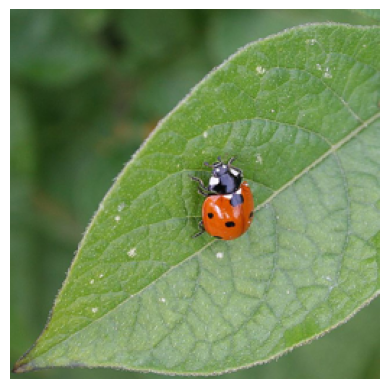

In [92]:
from re import I
index = 2
image = keras.utils.load_img(train_data_path + os.listdir(train_data_path)[index])
image = image.resize((256, 256))
image_arr = keras.utils.img_to_array(image)/255.0
print(image_arr.shape)
print(image_arr.dtype)
print(np.max(image_arr), np.min(image_arr))
print(type(image))
plt.imshow(image_arr)
plt.axis('off')
plt.show()

In [71]:
wrong_shape_cnt = 0
for filename in tqdm(os.listdir(train_data_path)):
    image = keras.utils.load_img(train_data_path + filename)
    image_arr = keras.utils.img_to_array(image)
    if len(image_arr.shape) !=3 or image_arr.shape[2] != 3:
        wrong_shape_cnt += 0

print(wrong_shape_cnt)

100%|██████████| 45000/45000 [05:58<00:00, 125.63it/s]

0


# Datagenerator

In [138]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, directory_path, batch_size, input_size=(256, 256), inpaint_min_size=20, inpaint_max_size=50, shuffle = True):
        if not os.path.exists(directory_path):
            raise Exception("Directory not found")
        self.directory_path = directory_path
        self.batch_size = batch_size
        self.n = len(os.listdir(directory_path))
        self.data_filenames = os.listdir(directory_path)
        self.input_size = input_size
        self.inpaint_min_size = inpaint_min_size
        self.inpaint_max_size = inpaint_max_size
        self.shuffle = shuffle

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch_filenames = self.data_filenames[index * self.batch_size: (index + 1) * self.batch_size]
        batch_images = []
        for filename in batch_filenames:
            image = self.load_image(filename)
            batch_images.append(image)
        masked_images = [self.mask_image(np.copy(im)) for im in batch_images]
        x_data = np.stack(masked_images, axis=0)
        y_data = np.stack(batch_images, axis=0)
        return x_data, y_data

    def load_image(self, filename):
        image = keras.utils.load_img(self.directory_path + filename)
        image = image.resize(self.input_size)
        image_arr = keras.utils.img_to_array(image)/255.0
        return image_arr

    def mask_image(self, image):
        x_size = np.random.randint(self.inpaint_min_size, self.inpaint_max_size)
        y_size = np.random.randint(self.inpaint_min_size, self.inpaint_max_size)
        x_middle = np.random.randint(x_size, self.input_size[0]-x_size)
        y_middle = np.random.randint(y_size, self.input_size[1]-y_size)
        image[x_middle-x_size:x_middle+x_size, y_middle-y_size:y_middle+y_size, :] = 0
        return image

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.data_filenames)


In [139]:
dg = DataGenerator(train_data_path, 8)
len(dg)

5625

(8, 256, 256, 3) (8, 256, 256, 3)
float32


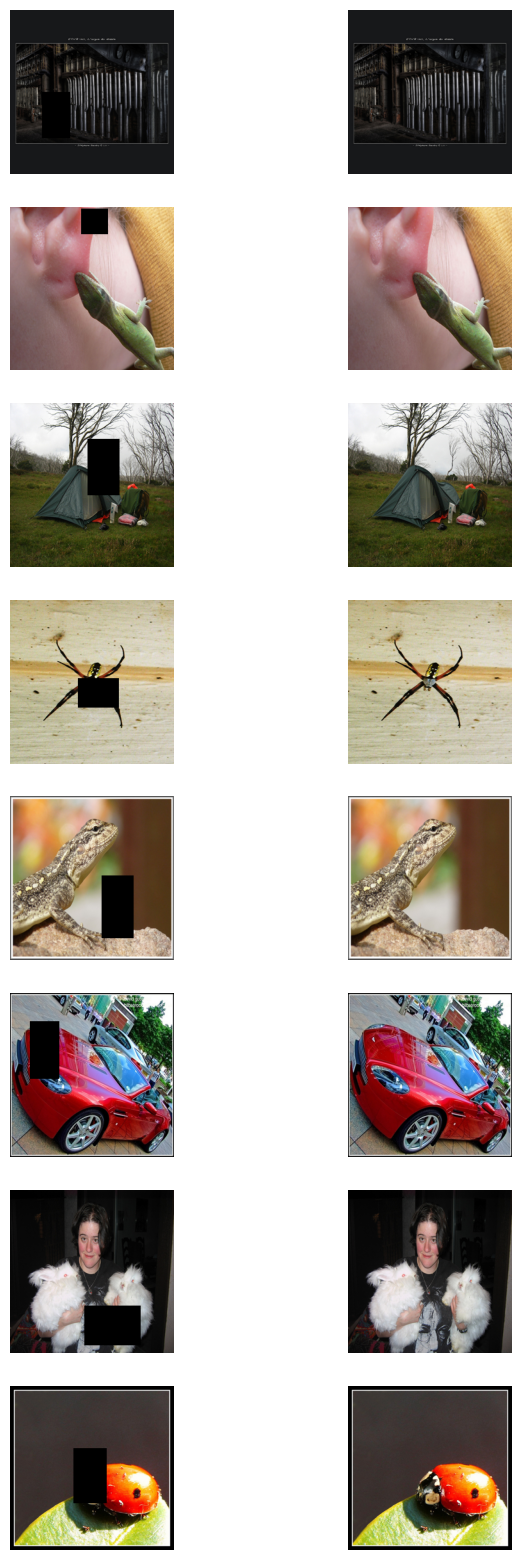

In [140]:
x, y = dg[1]
print(x.shape, y.shape)
print(x.dtype)

fig, axs = plt.subplots(8, 2, figsize=(8, 20))
plt.axis('off')
for i in range(8):
    axs[i, 0].imshow(x[i])
    axs[i, 0].axis('off')
    axs[i, 1].imshow(y[i])
    axs[i, 1].axis('off')
plt.show()